# ECSE 415 Final Project
# 2 Classification

In [1]:
# Import necessary packages
import cv2
import itertools
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate

## Import the dataset

In [2]:
# Function to load the images given the folder name
def load_folder(folder, num_samples):
    imgs = []
    files = listdir('./MIO-TCD-Classification/train/{}/'.format(folder))
    img_counter = 0
    for img in files:
        # Read the images in grayscale
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Classification/train/{}/{}'.format(folder,img)), cv2.COLOR_BGR2GRAY)
        # Perform a box blur on the images
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        # Resize to reduce computation time
        img = cv2.resize(img, (64,64))
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    print('Number of samples from ' + folder + '=' + str(len(imgs)))
    return imgs

In [3]:
# The number of images from each class to import
num_samples = 1751
# Import images from each folder
articulated_truck = load_folder('articulated_truck', num_samples)
background = load_folder('background', num_samples)
bicycle = load_folder('bicycle', num_samples)
bus = load_folder('bus', num_samples)
car = load_folder('car', num_samples)
motorcycle = load_folder('motorcycle', num_samples)
non_motorized_vehicle = load_folder('non-motorized_vehicle', num_samples)
pedestrian = load_folder('pedestrian', num_samples)
pickup_truck = load_folder('pickup_truck', num_samples)
single_unit_truck = load_folder('single_unit_truck', num_samples)
work_van = load_folder('work_van', num_samples)

Number of samples from articulated_truck=1751
Number of samples from background=1751
Number of samples from bicycle=1751
Number of samples from bus=1751
Number of samples from car=1751
Number of samples from motorcycle=1751
Number of samples from non-motorized_vehicle=1751
Number of samples from pedestrian=1751
Number of samples from pickup_truck=1751
Number of samples from single_unit_truck=1751
Number of samples from work_van=1751


## Compute HoG Features

In [4]:
# Function to compute HoG features of a list of images
# Adapted from Tutorial 4, Part 2
def compute_HoG(imgs, cell_size, block_size, nbins, h, w):
    img_features = []
    hog = cv2.HOGDescriptor(_winSize=((w // cell_size[1]) * cell_size[1],
                                  (h // cell_size[0]) * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    n_cells = (h // cell_size[0], w // cell_size[1])
    
    for img in imgs:

        hog_feats = hog.compute(img)\
                .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        # computation for BlockNorm

        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        
        img_features.append(gradients)
        
    return img_features

In [5]:
# Create the data and labels variables
X = articulated_truck + background + bicycle + bus + car + motorcycle + non_motorized_vehicle + pedestrian + pickup_truck + single_unit_truck + work_van
y = ['articulated_truck']*len(articulated_truck) + ['background']*len(background) + ['bicycle']*len(bicycle) + \
    ['bus']*len(bus) + ['car']*len(car) + ['motorcycle']*len(motorcycle) + ['non_motorized_vehicle']*len(non_motorized_vehicle)\
    + ['pedestrian']*len(pedestrian) + ['pickup_truck']*len(pickup_truck) + ['single_unit_truck']*len(single_unit_truck) + \
    ['work_van']*len(work_van)

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Define parameters for computing the HoG features
c_size = (4,4)
b_size = (4,4)
bins = 8
height = 64
width = 64

# Compute the HoG Features
HoG_feat = compute_HoG(X_train, c_size, b_size, bins, height, width)
HoG_feat = np.array(HoG_feat)

## Reduce dimensionality with PCA

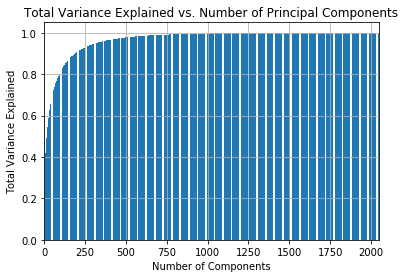

In [6]:
# Compute PCA for all components
pca = PCA(n_components = 2048)
X_PCA = pca.fit_transform(HoG_feat.reshape(HoG_feat.shape[0],-1))
# Find the variances explained
marginal_variances = pca.explained_variance_ratio_

# Plot the total variance explained at for n components
total_variances = [sum(marginal_variances[:i]) for i in range(1,len(marginal_variances)+1)]
plt.title("Total Variance Explained vs. Number of Principal Components")
plt.xlabel("Number of Components"), plt.ylabel("Total Variance Explained")
plt.bar(range(1, len(total_variances) + 1), total_variances)
plt.ylim(ymin=0), plt.xlim(xmin=0, xmax=2048)
plt.grid(True)
plt.show()

In [7]:
# Use the number of components representing 98% of the data
nb_components = next(x[0] for x in enumerate(total_variances) if x[1] > 0.98)
print('Number of components used: ' + str(nb_components))
pca = PCA(n_components = nb_components)
# Prepare training data
X_train_PCA = pca.fit_transform(HoG_feat.reshape(HoG_feat.shape[0],-1))
# Prepare test data
HoG_feat_test = compute_HoG(X_test, c_size, b_size, bins, height, width)
HoG_feat_test = np.array(HoG_feat_test)
X_test_PCA = pca.transform(HoG_feat_test.reshape(HoG_feat_test.shape[0],-1))

Number of components used: 533


## Train SVM
We have chosen the LinearSVC() model from sklearn as our SVM

In [8]:
# Fit the model
then = time.clock()
svc_clf = LinearSVC(C=1)
svc_clf.fit(X_train_PCA,y_train)
now = time.clock()
elapsed = now - then
print('Time to train LinearSVC = ' + str(elapsed))

Time to train LinearSVC = 13.979690721183747


## Train Logistic Regression model
The second non-deep learning model we have chosen is LogisticRegression() from the sklearn library

In [9]:
# Fit the model
then = time.clock()
lr_clf = LogisticRegression(C=10, solver='lbfgs',multi_class='multinomial')
lr_clf.fit(X_train_PCA,y_train)
now = time.clock()
elapsed = now - then
print('Time to train LogisticRegression = ' + str(elapsed))

Time to train LogisticRegression = 6.351877613652965


# 2.1 Classifier Evaluation

## Predict the classes of the test data

In [10]:
# Predict the classes using linear svc
then = time.clock()
svc_pred = svc_clf.predict(X_test_PCA)
now = time.clock()
elapsed = now - then
print('Time to predict using LinearSVC = ' + str(elapsed))
print('LinearSVC Prediction Results')
print(classification_report(y_test,svc_pred))

# Predict the classes using logistic regression
then = time.clock()
lr_pred = lr_clf.predict(X_test_PCA)
now = time.clock()
elapsed = now - then
print('Time to predict using LogisticRegression = ' + str(elapsed))
print('Logistic Regression Prediction Results')
print(classification_report(y_test,lr_pred))

Time to predict using LinearSVC = 0.005483231209179706
LinearSVC Prediction Results
                       precision    recall  f1-score   support

    articulated_truck       0.54      0.59      0.57       260
           background       0.69      0.74      0.71       253
              bicycle       0.70      0.67      0.69       255
                  bus       0.64      0.63      0.64       281
                  car       0.69      0.70      0.70       264
           motorcycle       0.64      0.67      0.65       242
non_motorized_vehicle       0.57      0.46      0.51       270
           pedestrian       0.59      0.59      0.59       252
         pickup_truck       0.63      0.61      0.62       271
    single_unit_truck       0.60      0.63      0.61       267
             work_van       0.56      0.60      0.58       275

          avg / total       0.62      0.62      0.62      2890

Time to predict using LogisticRegression = 0.004021919673043328
Logistic Regression Prediction

## K-fold Cross Validation

In [11]:
# Create the scoring metrics
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score, average='macro')}
# Perform k-fold cross validation for LinearSVC()
svc_results = cross_validate(svc_clf, X_train_PCA, y_train, cv=10, verbose=100, scoring = scoring)
# Perform k-fold cross validation for LogisticRegression()
lr_results = cross_validate(lr_clf, X_train_PCA, y_train, cv=10, verbose=100, scoring = scoring)

[CV]  ................................................................
[CV]  , accuracy=0.615478366849482, precision=0.6138455019302339, recall=0.6155159624741765, total=  12.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.6229408175716901, precision=0.6200003893526621, recall=0.6225960672435755, total=  12.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.3s remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.6540573520439292, precision=0.6524203947439511, recall=0.6537311211465617, total=  12.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.9s remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.6284319707138499, precision=0.6260364443123163, recall=0.6281830821364006, total=  12.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | e

In [12]:
print('LinearSVC() Cross Validation Results')
print('Test Accuracy:')
print('Average: ' + str(np.mean(svc_results['test_accuracy'])))
print('Standard Deviation: '+ str(np.std(svc_results['test_accuracy'])))

print('Test Precision:')
print('Average: ' + str(np.mean(svc_results['test_precision'])))

print('Test Recall:')
print('Average: ' + str(np.mean(svc_results['test_recall'])))

LinearSVC() Cross Validation Results
Test Accuracy:
Average: 0.6251277963350967
Standard Deviation: 0.011727320823758637
Test Precision:
Average: 0.6236580141411625
Test Recall:
Average: 0.6249002728542454


In [13]:
print('Logistic Regression() Cross Validation Results')
print('Test Accuracy:')
print('Average: ' + str(np.mean(lr_results['test_accuracy'])))
print('Standard Deviation: '+ str(np.std(lr_results['test_accuracy'])))

print('Test Precision:')
print('Average: ' + str(np.mean(lr_results['test_precision'])))

print('Test Recall:')
print('Average: ' + str(np.mean(lr_results['test_recall'])))

Logistic Regression() Cross Validation Results
Test Accuracy:
Average: 0.6312958860372
Standard Deviation: 0.012064357900473718
Test Precision:
Average: 0.6310705608647205
Test Recall:
Average: 0.6311118392115517


## Confusion Matrices

In [14]:
# Adapted from sklearn Confusion Matrix tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (12,12))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


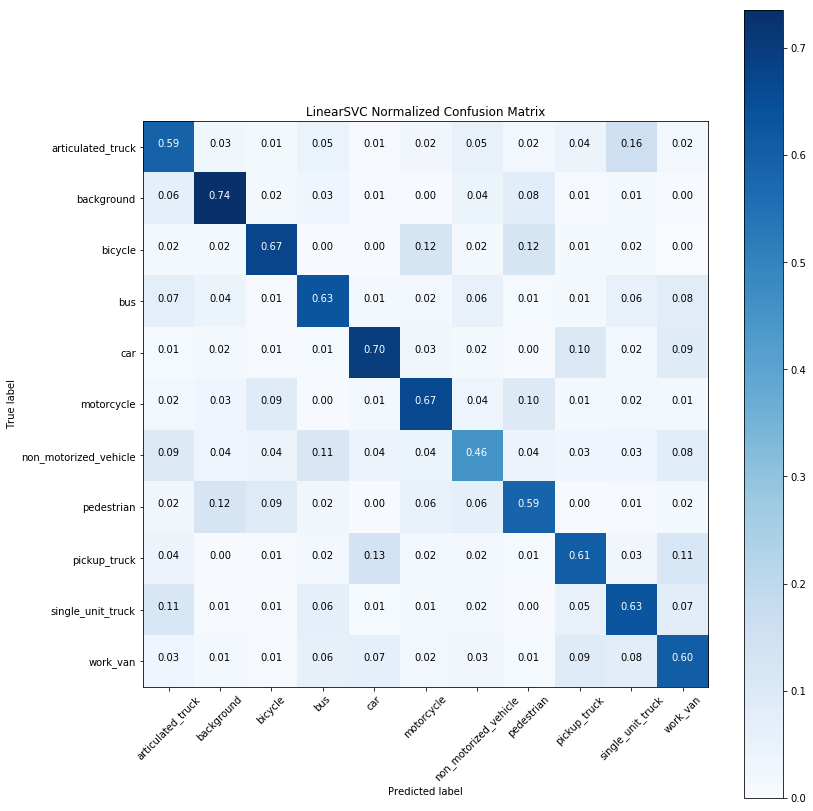

In [15]:
# Create the labels for the matrix
label = ['articulated_truck'] + ['background'] + ['bicycle'] + \
    ['bus'] + ['car'] + ['motorcycle'] + ['non_motorized_vehicle']\
    + ['pedestrian'] + ['pickup_truck'] + ['single_unit_truck'] + \
    ['work_van']

# Compute confusion matrix for LinearSVC()
svc_cnf_matrix = confusion_matrix(y_test, svc_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plot_confusion_matrix(svc_cnf_matrix, classes=label, normalize=True,
                      title='LinearSVC Normalized Confusion Matrix')

plt.show()

Normalized confusion matrix


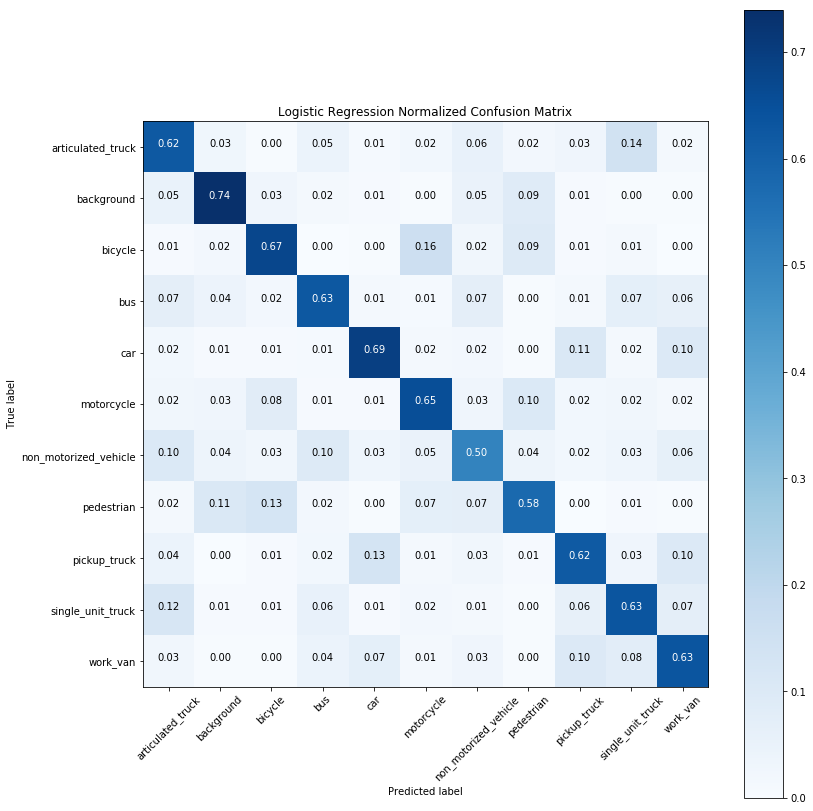

In [16]:
# Compute confusion matrix for LogisticRegression()
lr_cnf_matrix = confusion_matrix(y_test, lr_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(lr_cnf_matrix, classes=label, normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix')

plt.show()